## 1. Importation des bibliothèques

In [1]:
# =============================================================================
# IMPORT REQUIRED LIBRARIES
# =============================================================================
# This section imports all necessary libraries for the ML pipeline:
# - Data manipulation: pandas, numpy
# - Visualization: matplotlib, seaborn
# - Machine Learning: scikit-learn (regression, evaluation, feature selection)

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Chargement des données

In [2]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load the NYC Taxi dataset containing trip records from 2018.
# This dataset includes fare amounts, trip distances, durations, and other features.

df = pd.read_csv('datasets/original_cleaned_nyc_taxi_data_2018.csv')

print(f"Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
df.head()

Dataset loaded: 8,319,928 rows x 21 columns


,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,...,61.67,231,138,2018,3,29,3,13,3317.0,61.67
1,4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,...,62.47,87,138,2018,3,29,3,14,3648.0,62.47
2,5,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,...,63.13,68,138,2018,3,29,3,14,3540.0,63.13
3,10,5.10,1,N,1,26.5,1.0,0.5,5.65,0.00,...,33.95,186,33,2018,3,29,3,16,2585.0,33.95
4,12,11.11,1,N,1,45.5,1.0,0.5,10.61,5.76,...,63.67,163,138,2018,3,29,3,16,4521.0,63.67


## 3. Préparation des données

### 3.1 Échantillonnage
Le dataset est très grand (8M+ lignes). On prend un échantillon pour accélérer l'entraînement.

In [3]:
# =============================================================================
# DATA SAMPLING
# =============================================================================
# Due to the large size of the dataset (8M+ rows), we extract a random sample
# to reduce computational cost while maintaining statistical representativeness.
# Random state is fixed for reproducibility.

SAMPLE_SIZE = 100000  # 100k rows
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42)

print(f"Sample size: {df_sample.shape[0]:,} rows")

Sample size: 100,000 rows


### 3.2 Nettoyage des données
Supprimons les valeurs aberrantes et les colonnes inutiles.

In [4]:
# =============================================================================
# DATA CLEANING - OUTLIER REMOVAL
# =============================================================================
# Remove outliers based on domain knowledge:
# - fare_amount: must be positive and below $200 (extreme fares excluded)
# - trip_distance: must be positive and below 100 miles (unrealistic distances excluded)
# - trip_duration: between 1 minute and 2 hours (typical trip duration range)
# These thresholds help ensure data quality and model reliability.

df_clean = df_sample[
    (df_sample['fare_amount'] > 0) & 
    (df_sample['fare_amount'] < 200) &
    (df_sample['trip_distance'] > 0) & 
    (df_sample['trip_distance'] < 100) &
    (df_sample['trip_duration'] > 60) &
    (df_sample['trip_duration'] < 7200)
].copy()

print(f"After cleaning: {df_clean.shape[0]:,} rows")
print(f"Rows removed: {df_sample.shape[0] - df_clean.shape[0]:,}")

After cleaning: 97,784 rows
Rows removed: 2,216


### 3.3 Définition des variables

In [5]:
# =============================================================================
# FEATURE AND TARGET VARIABLE DEFINITION
# =============================================================================
# Target variable (y): fare_amount - the price of the taxi ride
# Feature variables (X): selected based on domain relevance and correlation analysis
# Note: Features were chosen for their potential predictive power on fare pricing.

y = df_clean['fare_amount']

# Selected features based on correlation with fare_amount
features = ['trip_distance', 'rate_code', 'payment_type', 'extra', 'mta_tax', 'tip_amount']

X = df_clean[features]

print(f"Target variable: fare_amount")
print(f"Features ({len(features)}): {features}")
print(f"\nX dimensions: {X.shape}")
print(f"y dimensions: {y.shape}")

Target variable: fare_amount
Features (6): ['trip_distance', 'rate_code', 'payment_type', 'extra', 'mta_tax', 'tip_amount']

X dimensions: (97784, 6)
y dimensions: (97784,)


## 4. Analyse des corrélations

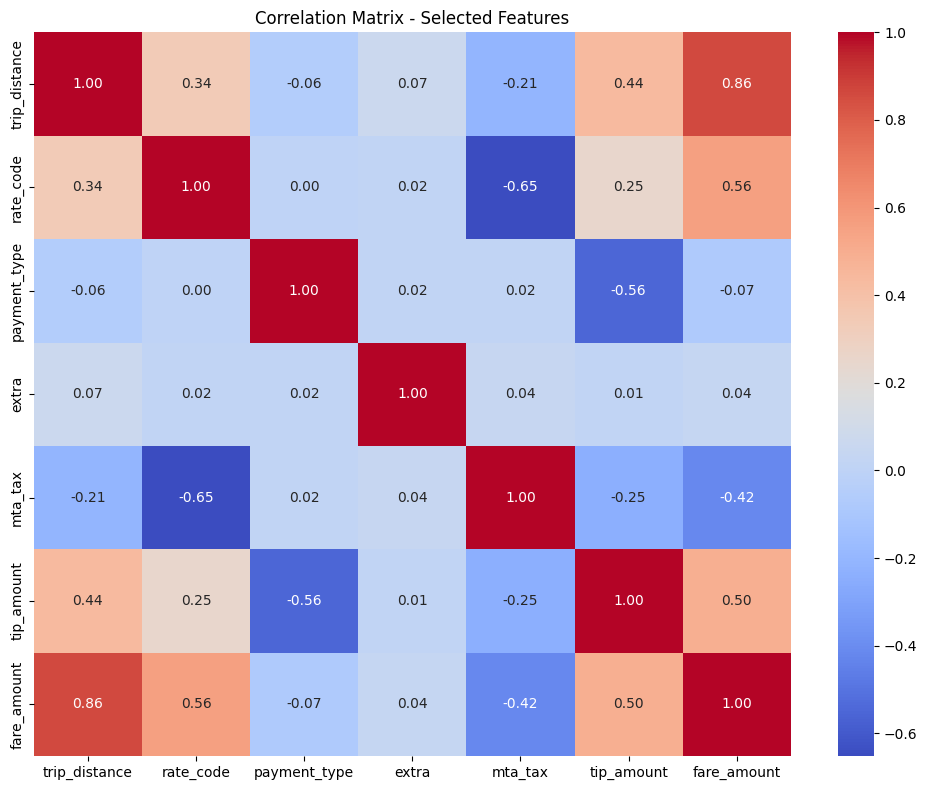

In [6]:
# =============================================================================
# CORRELATION MATRIX - SELECTED FEATURES
# =============================================================================
# Visualize pairwise correlations between selected features and target variable.
# Correlation coefficients range from -1 (perfect negative) to +1 (perfect positive).
# This helps identify multicollinearity issues and feature-target relationships.

plt.figure(figsize=(10, 8))
corr_data = pd.concat([X, y], axis=1)
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix - Selected Features')
plt.tight_layout()
plt.show()

### 4.1 Matrice de corrélation COMPLÈTE (toutes les colonnes)
Voyons les corrélations avec TOUTES les variables pour identifier celles qui sont vraiment intéressantes.

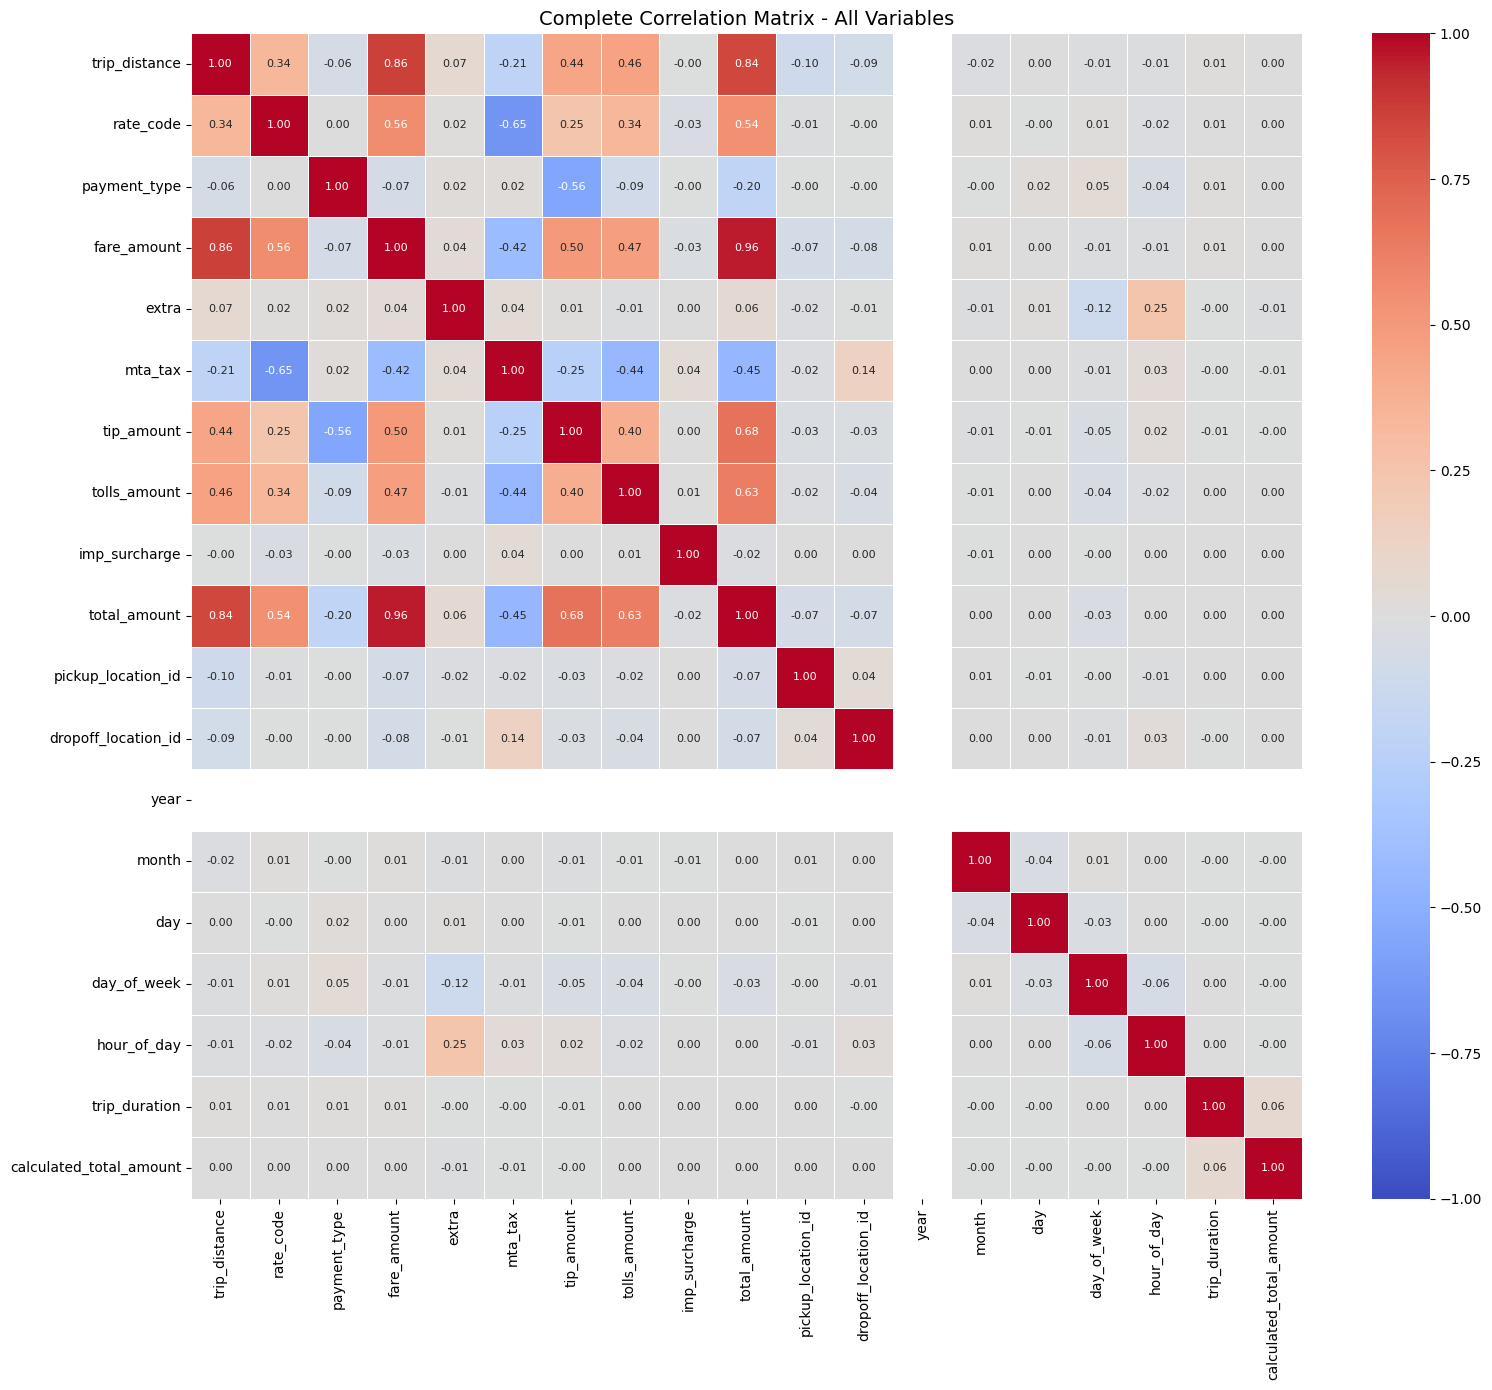


CORRELATIONS WITH fare_amount (sorted by importance)
total_amount              : +0.9606  [very strong]
trip_distance             : +0.8597  [very strong]
rate_code                 : +0.5598  [strong]
tip_amount                : +0.4951  [moderate]
tolls_amount              : +0.4713  [moderate]
mta_tax                   : -0.4190  [moderate]
dropoff_location_id       : -0.0760  [weak]
pickup_location_id        : -0.0747  [weak]
payment_type              : -0.0724  [weak]
extra                     : +0.0360  [weak]
imp_surcharge             : -0.0257  [weak]
day_of_week               : -0.0144  [weak]
month                     : +0.0096  [weak]
hour_of_day               : -0.0087  [weak]
trip_duration             : +0.0080  [weak]
calculated_total_amount   : +0.0024  [weak]
day                       : +0.0024  [weak]
year                      : +nan  [weak]


In [7]:
# =============================================================================
# COMPLETE CORRELATION MATRIX - ALL NUMERIC VARIABLES
# =============================================================================
# Comprehensive correlation analysis across all numeric columns to identify
# potential features and understand variable relationships.
# Correlation strength interpretation:
# - |r| >= 0.7: Very strong correlation
# - |r| >= 0.5: Strong correlation
# - |r| >= 0.3: Moderate correlation
# - |r| < 0.3: Weak correlation

all_numeric = df_clean.select_dtypes(include=[np.number])

# Exclude irrelevant columns
cols_to_exclude = ['Unnamed: 0']
all_numeric = all_numeric.drop(columns=[c for c in cols_to_exclude if c in all_numeric.columns])

plt.figure(figsize=(16, 14))
full_corr = all_numeric.corr()
sns.heatmap(full_corr, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Complete Correlation Matrix - All Variables', fontsize=14)
plt.tight_layout()
plt.show()

# Display correlations with fare_amount sorted by absolute value
print("\n" + "="*60)
print("CORRELATIONS WITH fare_amount (sorted by importance)")
print("="*60)
fare_corr = full_corr['fare_amount'].drop('fare_amount').sort_values(key=abs, ascending=False)
for var, corr in fare_corr.items():
    strength = "[very strong]" if abs(corr) >= 0.7 else "[strong]" if abs(corr) >= 0.5 else "[moderate]" if abs(corr) >= 0.3 else "[weak]"
    print(f"{var:25} : {corr:+.4f}  {strength}")

## 5. Test de significativité des variables (F-test)

In [8]:
# =============================================================================
# FEATURE SIGNIFICANCE TEST (F-TEST)
# =============================================================================
# The F-test evaluates the statistical significance of each feature in predicting
# the target variable. It tests the null hypothesis that the feature has no
# linear relationship with the target.
#
# Interpretation:
# - F-value: Higher values indicate stronger linear relationship
# - P-value: Probability of observing the result if null hypothesis is true
#   - p < 0.05: Feature is statistically significant (reject null hypothesis)
#   - p >= 0.05: Feature may not contribute significantly
#
# Limitations: F-test assumes linear relationships and may miss non-linear patterns.

f_values, p_values = f_regression(X, y)

# Create summary table
pval_table = pd.DataFrame({
    'Variable': X.columns,
    'F_value': f_values,
    'P_value': p_values
})

# Format for readability
pval_table['F_value'] = pval_table['F_value'].map('{:.2f}'.format)
pval_table['P_value'] = pval_table['P_value'].apply(
    lambda x: f'{x:.2e}' if x < 0.01 else f'{x:.3f}'
)

# Sort by significance
pval_table = pval_table.sort_values(by='P_value')

print("Feature Significance Test Results:")
print("=" * 50)
print(pval_table.to_string(index=False))
print("\nNote: Variables with p-value < 0.05 are statistically significant")

Feature Significance Test Results:
     Variable   F_value   P_value
trip_distance 277089.96  0.00e+00
    rate_code  44638.43  0.00e+00
      mta_tax  20822.99  0.00e+00
   tip_amount  31748.26  0.00e+00
        extra    126.83  2.11e-29
 payment_type    515.78 6.91e-114

Note: Variables with p-value < 0.05 are statistically significant


## 6. Division Train/Test

In [9]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================
# Split data into training (80%) and testing (20%) sets.
# - Training set: Used to fit the model parameters
# - Test set: Used to evaluate model performance on unseen data
# Random state ensures reproducibility of the split.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set: {X_test.shape[0]:,} rows")

Training set: 78,227 rows
Test set: 19,557 rows


## 7. Entraînement du modèle

In [10]:
# =============================================================================
# MODEL TRAINING - LINEAR REGRESSION
# =============================================================================
# Linear Regression assumes a linear relationship between features and target:
# y = b0 + b1*x1 + b2*x2 + ... + bn*xn
# The model minimizes the sum of squared residuals (Ordinary Least Squares).

model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained successfully")

Model trained successfully


## 8. Prédictions

In [11]:
# =============================================================================
# PREDICTIONS ON TEST SET
# =============================================================================
# Generate predictions for the held-out test set to evaluate model performance.
# Comparing predicted vs actual values helps assess model accuracy.

y_pred = model.predict(X_test)

# Preview predictions vs actual values
comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10],
    'Error': abs(y_test.values[:10] - y_pred[:10])
})
print("Prediction Preview (first 10 samples):")
print(comparison.round(2))

Prediction Preview (first 10 samples):
   Actual  Predicted  Error
0    23.5      27.24   3.74
1    22.5      24.63   2.13
2    31.5      35.85   4.35
3    25.0      24.57   0.43
4    61.0      60.19   0.81
5    24.5      24.23   0.27
6    52.0      53.47   1.47
7    22.0      19.33   2.67
8    31.5      33.18   1.68
9    37.0      41.90   4.90


## 9. Évaluation du modèle

In [12]:
# =============================================================================
# MODEL EVALUATION METRICS
# =============================================================================
# Multiple metrics are used to comprehensively evaluate regression performance.
# Using complementary metrics provides a more complete picture than any single metric.
#
# --- R-SQUARED (R2) SCORE ---
# What it measures: Proportion of variance in the target explained by the model.
# Range: 0 to 1 (can be negative for poor models)
# Interpretation: Higher is better; R2=0.8 means 80% variance explained.
# Limitations: Can be misleading with many features (use Adjusted R2 instead);
#              does not indicate prediction accuracy in original units.
#
# --- ROOT MEAN SQUARED ERROR (RMSE) ---
# What it measures: Square root of average squared prediction errors.
# Units: Same as target variable (dollars in this case).
# Interpretation: Lower is better; penalizes large errors more heavily.
# Limitations: Sensitive to outliers; scale-dependent (not comparable across datasets).
#
# --- MEAN ABSOLUTE ERROR (MAE) ---
# What it measures: Average absolute difference between predictions and actuals.
# Units: Same as target variable (dollars).
# Interpretation: Lower is better; more robust to outliers than RMSE.
# Limitations: Does not penalize large errors as much as RMSE.
#
# COMPLEMENTARITY OF METRICS:
# - R2 indicates overall explanatory power (relative measure)
# - RMSE and MAE provide error magnitude in interpretable units (absolute measures)
# - Comparing RMSE vs MAE: If RMSE >> MAE, large errors are present
# =============================================================================

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"\nR2 Score: {r2:.4f} ({r2*100:.2f}% variance explained)")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print("\n" + "=" * 50)

# Performance interpretation
if r2 > 0.8:
    print("Excellent - Model explains the data very well.")
elif r2 > 0.6:
    print("Good - Acceptable model performance.")
elif r2 > 0.4:
    print("Moderate - Model can be improved.")
else:
    print("Weak - Features insufficient to explain target variability.")

MODEL EVALUATION METRICS

R2 Score: 0.8316 (83.16% variance explained)
RMSE: $5.96
MAE: $3.64

Excellent - Model explains the data very well.


## 10. Visualisation des résultats

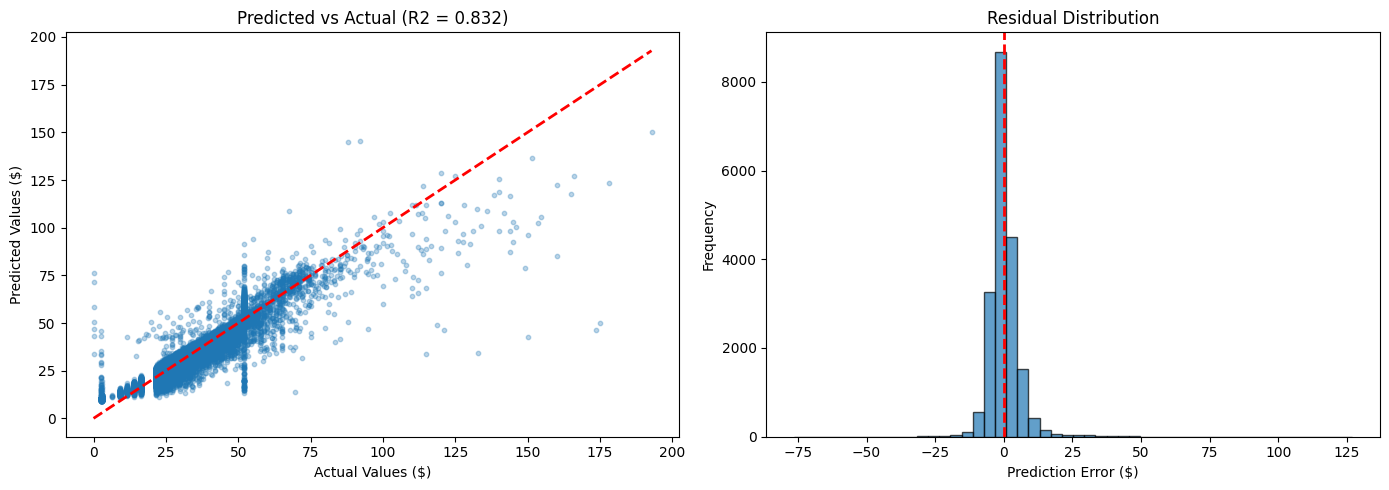

In [13]:
# =============================================================================
# RESULTS VISUALIZATION
# =============================================================================
# Two complementary plots for model diagnostics:
# 1. Predicted vs Actual: Points should align with diagonal for perfect predictions
# 2. Residual Distribution: Should be centered at 0 and approximately normal

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Values ($)')
axes[0].set_ylabel('Predicted Values ($)')
axes[0].set_title(f'Predicted vs Actual (R2 = {r2:.3f})')

# Residual distribution
residuals = y_test - y_pred
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

## 11. Formule de la régression linéaire

In [14]:
# =============================================================================
# LINEAR REGRESSION EQUATION
# =============================================================================
# Display the fitted model parameters:
# - Intercept (b0): baseline fare when all features equal zero
# - Coefficients (b1...bn): change in fare per unit change in each feature

intercept = model.intercept_
coefficients = model.coef_

print("Model Coefficients:")
print("=" * 50)
print(f"Intercept (b0): {intercept:.4f}")
print("\nFeature Coefficients:")
for var, coef in zip(X.columns, coefficients):
    print(f"  {var}: {coef:.4f}")

# Generate the regression formula
print("\n" + "=" * 50)
print("LINEAR REGRESSION FORMULA:")
print("=" * 50)
formula = f"fare_amount = {intercept:.2f}"
for var, coef in zip(X.columns, coefficients):
    sign = '+' if coef >= 0 else '-'
    formula += f" {sign} {abs(coef):.4f}*{var}"

print(formula)

Model Coefficients:
Intercept (b0): 10.8326

Feature Coefficients:
  trip_distance: 2.0944
  rate_code: 5.6139
  payment_type: 1.3566
  extra: -0.3994
  mta_tax: -17.4233
  tip_amount: 0.4131

LINEAR REGRESSION FORMULA:
fare_amount = 10.83 + 2.0944*trip_distance + 5.6139*rate_code + 1.3566*payment_type - 0.3994*extra - 17.4233*mta_tax + 0.4131*tip_amount


## 12. Importance des variables

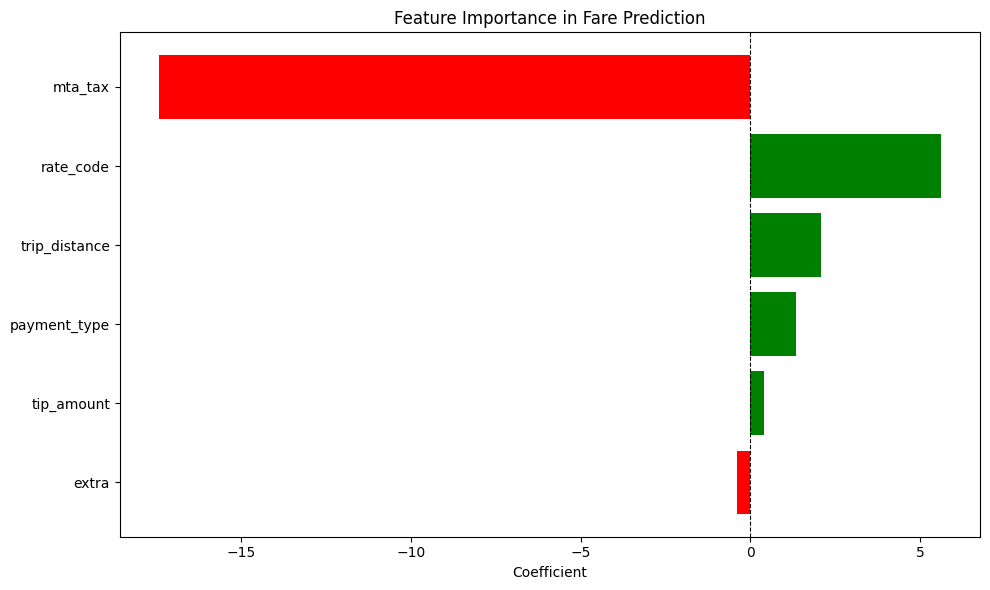


Legend:
  Green = Positive impact on fare
  Red = Negative impact on fare


In [15]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
# Visualize the magnitude and direction of each feature's contribution.
# Note: Coefficients are not normalized; interpretation depends on feature scales.
# Positive coefficients increase fare; negative coefficients decrease fare.

importance = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in importance['Coefficient']]
plt.barh(importance['Variable'], importance['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Feature Importance in Fare Prediction')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\nLegend:")
print("  Green = Positive impact on fare")
print("  Red = Negative impact on fare")

## 13. Sauvegarde du modèle (optionnel)

In [16]:
# =============================================================================
# MODEL PERSISTENCE
# =============================================================================
# Save the trained model for future use without retraining.
# Joblib is efficient for scikit-learn models with large numpy arrays.

import joblib

joblib.dump(model, 'fare_prediction_model.pkl')
print("Model saved: fare_prediction_model.pkl")

Model saved: fare_prediction_model.pkl


## 14. Résumé final

In [17]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("=" * 60)
print("MODEL SUMMARY - NYC TAXI FARE PREDICTION")
print("=" * 60)

print(f"\nTarget Variable: fare_amount")
print(f"\nFeatures Used ({len(features)}):")
for f in features:
    print(f"   - {f}")

print(f"\nPERFORMANCE METRICS:")
print(f"   - R2 Score: {r2:.4f} ({r2*100:.2f}%)")
print(f"   - RMSE: ${rmse:.2f}")
print(f"   - MAE: ${mae:.2f}")

print(f"\nDATASET:")
print(f"   - Total sample: {len(df_clean):,} rows")
print(f"   - Training set: {len(X_train):,} rows")
print(f"   - Test set: {len(X_test):,} rows")

print("\n" + "=" * 60)

# =============================================================================
# EVALUATION METRICS SUMMARY
# =============================================================================
# 
# METRICS USED IN THIS PROJECT:
# 1. R-Squared (R2): Measures proportion of variance explained (0-1 scale)
# 2. RMSE: Average prediction error magnitude, penalizes large errors
# 3. MAE: Average absolute error, more robust to outliers
#
# WHAT THESE METRICS EVALUATE:
# - Model's ability to capture linear relationships in the data
# - Prediction accuracy in monetary terms (RMSE/MAE in dollars)
# - Overall explanatory power of selected features (R2)
#
# LIMITATIONS OF THIS EVALUATION:
# - Linear regression assumes linear feature-target relationships
# - R2 can be artificially inflated with many features
# - RMSE/MAE are scale-dependent; cannot compare across different datasets
# - No cross-validation performed; results may vary with different splits
# - Heteroscedasticity and non-normality of residuals not formally tested
# - Feature coefficients not standardized; direct comparison is limited
# =============================================================================

MODEL SUMMARY - NYC TAXI FARE PREDICTION

Target Variable: fare_amount

Features Used (6):
   - trip_distance
   - rate_code
   - payment_type
   - extra
   - mta_tax
   - tip_amount

PERFORMANCE METRICS:
   - R2 Score: 0.8316 (83.16%)
   - RMSE: $5.96
   - MAE: $3.64

DATASET:
   - Total sample: 97,784 rows
   - Training set: 78,227 rows
   - Test set: 19,557 rows

